In [6]:
from pathlib import Path

from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import librosa.display
import soundfile as sf

## データ確認

- patient_diagnosis.csv の確認

    - pid: 患者ID

    - disease: 病名

In [8]:
patient_data = pd.read_csv('../dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['pid', 'disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


- 音声ファイルと同ディレクトリにある「txt.」ファイルの確認

    - start: 呼吸の始まり
    
    - end: 呼吸の終わり
    
    - crackles: 呼吸器系の破裂音などの有無(https://www.almediaweb.jp/glossary/0236.html#:~:text=肺の聴診で聞か,性、断続性の音。) => 1: 発生している, 0: 発生していない

    - weezels: 喘息の有無 => 1: 発生している, 0: 発生していない

In [9]:
df = pd.read_csv('../dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt', sep='\t', names=['start', 'end', 'crackles', 'weezels'])
df.head()

,start,end,crackles,weezels
0,1.862,5.718,0,1
1,5.718,9.725,1,1
2,9.725,13.614,0,1
3,13.614,17.671,0,1
4,17.671,19.541,0,0


- 音声ファイル: 命名規則は下記の通り

  患者id_レコードid_胸の位置_取得モード_機器
  
  - 胸の位置
  
    a. Trachea (Tc)
    
    b. Anterior left (Al) 
    
    c. Anterior right (Ar)
    
    d. Posterior left (Pl)
    
    e. Posterior right (Pr)
    
    f. Lateral left (Ll)
    
    g. Lateral right (Lr)

  - 取得モード

    a. シングルチャンネルモード(sc)
        
    b. マルチチャンネルモード(mc)


In [3]:
file_list = list(Path('../dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/').glob('*.txt'))
file_list = [file_path.stem for file_path in file_list]
file_list[0]

'130_1p4_Pl_mc_AKGC417L'

In [4]:
def get_file_name_info(filename: str):
    return filename.split('_')

In [19]:
get_file_name_info(file_list[0])

['130', '1p4', 'Pl', 'mc', 'AKGC417L']

## txtファイル名とその中身からメタ情報データフレームを作成

In [5]:
files_data = []
data_path = '../dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
for file in file_list:
    data = pd.read_csv(
        str(Path(data_path) / f'{file}.txt'),
        sep='\t',
        names=['start', 'end', 'crackles', 'weezels']
    )
    file_name_data = get_file_name_info(file)
    data['pid'] = file_name_data[0]
    data['mode'] = file_name_data[-2]
    data['filename'] = file
    files_data.append(data)
files_df = pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.089,2.875,0,1,130,mc,130_1p4_Pl_mc_AKGC417L
1,2.875,6.137,0,1,130,mc,130_1p4_Pl_mc_AKGC417L
2,6.137,8.994,0,1,130,mc,130_1p4_Pl_mc_AKGC417L
3,8.994,11.875,0,1,130,mc,130_1p4_Pl_mc_AKGC417L
4,11.875,14.554,0,1,130,mc,130_1p4_Pl_mc_AKGC417L


## 患者情報df(patient_diagnosis.csv)とファイルメタ情報dfを「pid」をキーとして結合

In [6]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 3
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [10]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [11]:
files_df['pid'] = files_df['pid'].astype('int32')
patient_data['pid'] = patient_data['pid'].astype('int32')

In [12]:
data = files_df.merge(patient_data, on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,0.089,2.875,0,1,130,mc,130_1p4_Pl_mc_AKGC417L,COPD
1,2.875,6.137,0,1,130,mc,130_1p4_Pl_mc_AKGC417L,COPD
2,6.137,8.994,0,1,130,mc,130_1p4_Pl_mc_AKGC417L,COPD
3,8.994,11.875,0,1,130,mc,130_1p4_Pl_mc_AKGC417L,COPD
4,11.875,14.554,0,1,130,mc,130_1p4_Pl_mc_AKGC417L,COPD


In [13]:
csv_save_dir_path = Path('../dataset/csv_data')
csv_save_dir_path.mkdir(exist_ok=True)
data.to_csv(str(csv_save_dir_path / 'data.csv'), index=False)

## 音声ファイルの前処理と保存

In [2]:
def get_pure_sample(raw_data: np.ndarray, start: float, end: float, sampling_rate=22050):
    """生データのstart~endを切り抜く
    Args:
        raw_data: 音声データ
        start: 開始時間(sec)
        end: 終了時間(sec)
        sampling_rate: サンプリングレート(Hz)
    """
    data_length = len(raw_data)
    # start(sec)とsampling_rate(22050 Hz = 1/sec)をかけて最初データインデックスを取得
    start_idx = min(int(start * sampling_rate), data_length)
    # end(sec)とsampling_rate(22050 Hz = 1/sec)をかけて最終データインデックスを取得
    end_idx = min(int(end * sampling_rate), data_length)
    return raw_data[start_idx:end_idx]

音声の開始 ~ 終了の分布確認

- 外れ値を除くと概ね6秒程度

    - 6秒以下のデータは0埋めなどで対応
    
    - 6秒を超える場合は、end=start〜6秒までを取得する
   

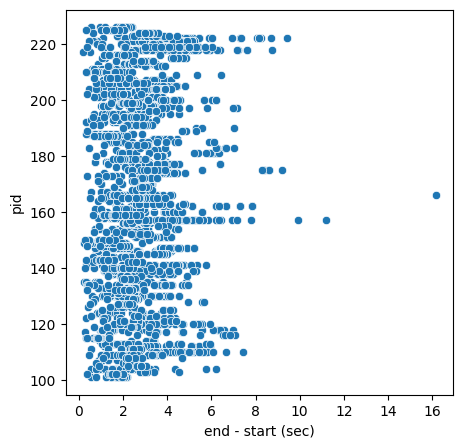

In [3]:
data = pd.read_csv('../dataset/csv_data/data.csv')
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=(data['end'] - data['start']), y=data['pid'], ax=ax)
ax.set_xlabel('end - start (sec)')
plt.show()

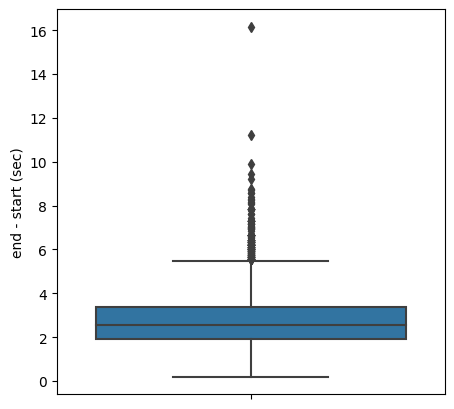

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(y=(data['end'] - data['start']), ax=ax)
ax.set_ylabel('end - start (sec)')
plt.show()

In [13]:
file_id, file_num_counter = 0, 0
max_len = 6
data = pd.read_csv('../dataset/csv_data/data.csv')
src_audio_path_dir = Path('../dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/')
dst_audio_path_dir = Path('../dataset/preprocessed_audio_files')
dst_audio_path_dir.mkdir(exist_ok=True)
for index, row in tqdm(data.iterrows(), total=len(data)):
    start = row['start']
    end = row['end']
    filename = row['filename']
    
    # 音声ファイルの読み込み
    src_audio_path = src_audio_path_dir / f'{filename}.wav'
    audio_arr, sample_rate = lb.load(src_audio_path)
    # 開始 ~ 終了の長さが6秒より大きい場合は、終了を開始〜6秒にする。
    if end - start > max_len:
        end = start + max_len
    pure_sample = get_pure_sample(audio_arr, start, end, sample_rate)

    # max_len以下の長さをパディング
    require_length = max_len * sample_rate
    padded_data = lb.util.pad_center(pure_sample, require_length)
    
    # ファイルの出力
    if index > 0:
        # 同じファイルが続く場合は、「元ファイル名_i.wav」として保存するため、iを1増やす
        if data.iloc[index - 1]['filename'] == filename:
            file_id += 1
        # 新規ファイルに該当するので、iを0で初期化
        else:
            file_id = 0
    dst_filename = f'{filename}_{file_id}.wav'
    dst = dst_audio_path_dir / dst_filename
    sf.write(file=dst, data=padded_data, samplerate=sample_rate)
    file_num_counter += 1
print(f'file num: {file_num_counter}')

  0% 0/6898 [00:00<?, ?it/s]/tmp/ipykernel_14/2652401171.py:21: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  padded_data = lb.util.pad_center(pure_sample, require_length)
100% 6898/6898 [39:41<00:00,  2.90it/s]

file num: 6898
